# Time series using rioxarray and stackstac {.unnumbered}

This notebook demonstrates how to generate a timeseries via `rioxarray`, `pystac_client` and `stackstac`.

* Author: Aimee Barciauskas
* Lasted Updated Date: August 3, 2022

In [1]:
import rioxarray
import stackstac
from pystac_client import Client

# Accessing the data

The data is in a protected bucket. Please request access by emailng aimee@developmentseed.org providing your affiliation, interest in or expected use of the dataset, and an AWS IAM role or user Amazon Resource Name (ARN). Once you have provided the role you will use to access the data, the team will add that role or user ARN to the permitted list of identities which can assume a role with read access to the data. The code in `create_rio_session.py` can then be used to assume this read-access role, identified in that code by the environment variable `AWS_ROLE`.

In [2]:
# Skip this if running in AWS Sagemaker
%run -i 'create_rio_session.py'

# Declare your collection of interest

You can discover available collections the following ways:

* Use the `{STAC_API_URL}/collections` API endpoint (JSON response)
* Programmatically using `pystac` (see example in the `list-collections.ipynb` notebook
* In the STAC Browser: http://delta-staging-stac-browser.s3-website-us-east-1.amazonaws.com/

In [3]:
STAC_API_URL = 'https://staging-stac.delta-backend.com/'
collection = 'no2-monthly'

## Use satsearch to discover items in the no2-monthly collection for China

In [4]:
china_bbox = [
    73.675,
    18.198,
    135.026,
    53.459
]
datetime = "2000-01-01T00:00:00Z/2022-01-02T00:00:00Z"
client = Client.open(STAC_API_URL)

search = client.search(
    bbox=china_bbox,
    datetime=datetime,
    collections=[collection],
    limit=1000
)
items = list(search.items())

In [5]:
len(items)

73

## Create an `xarray.DataArray` using `stackstac`

In [6]:
stack = stackstac.stack([item.to_dict() for item in items])
stack = stack.assign_coords({"time": stack.start_datetime})
stack

,Array,Chunk
Bytes,3.52 GiB,8.00 MiB
Shape,"(73, 1, 1800, 3600)","(1, 1, 1024, 1024)"
Count,730 Tasks,584 Chunks
Type,float64,numpy.ndarray


## Clip the data to the bounding box for China

In [7]:
# Subset to Bounding Box for China
subset = stack.rio.clip_box(
    minx=china_bbox[0],
    miny=china_bbox[1],
    maxx=china_bbox[2],
    maxy=china_bbox[3]
)
subset

/Users/leo/development-seed/veda/veda-documentation/env-veda-documentation/lib/python3.8/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


,Array,Chunk
Bytes,121.06 MiB,1.44 MiB
Shape,"(73, 1, 354, 614)","(1, 1, 354, 535)"
Count,876 Tasks,146 Chunks
Type,float64,numpy.ndarray


## Select a band of data

There is just one band in this case, `cog_default`.

In [8]:
# select the band default
data_band = subset.sel(band='cog_default')
data_band

<xarray.DataArray 'stackstac-740a0380f207bcf938f246dd20467d73' (time: 73,
                                                                y: 354, x: 614)>
dask.array<getitem, shape=(73, 354, 614), dtype=float64, chunksize=(1, 354, 535), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) <U20 '2022-01-01T00:00:00Z' ... '2016-01-01T00:00:...
    id              (time) <U45 'OMI_trno2_monthly_0.10x0.10_202201_Col3_V4.n...
    band            <U11 'cog_default'
  * x               (x) float64 73.7 73.8 73.9 74.0 ... 134.7 134.8 134.9 135.0
  * y               (y) float64 53.5 53.4 53.3 53.2 53.1 ... 18.5 18.4 18.3 18.2
    end_datetime    (time) <U20 '2022-01-31T00:00:00Z' ... '2016-01-31T00:00:...
    ...              ...
    proj:transform  object {0.1, 0.0, 1.0, -0.1, -180.0, 90.0}
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-180.0, -90....
    proj:bbox       object {90.0, 180.0, -90.0, -180.0}
    start_datetime  (time) <U20 '2022-01-01T00:00:00Z' ... '2016-01-01T00:00:...
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    resolution:  0.1

In [9]:
# Group data into months
dates = data_band.groupby('time')

In [10]:
# Average over entire spatial bounding box for each month
means = dates.mean(dim=('x', 'y'))

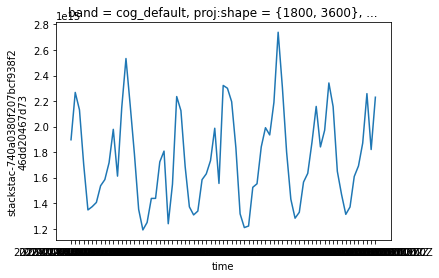

In [11]:
means.plot()

In [13]:
os.environ['AWS_ROLE']

'arn:aws:iam::853558080719:role/vedaDataAccessRole'